In [1]:
from microstructpy.markets.continous import ContinousDoubleAuction
from microstructpy.traders.noise import *
from microstructpy.traders.market_maker import *
from microstructpy.traders.informed import *
from microstructpy.traders.ensemble import ensemble_traders
from microstructpy.visualization.summary import participant_comparison, price_path
from microstructpy.metrics.trader import *
from microstructpy.metrics.market import *
from microstructpy.markets.continous import ContinousDoubleAuction
import microstructpy.traders.policies as pol 
from functools import partial
import seaborn as sns
import decimal
from collections import defaultdict
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

In [2]:
market = ContinousDoubleAuction(initial_fair_price=1000)
mm1 = BaseMarketMaker(market, fair_price_strategy=pol.fairprice_orderflow_sign(10, 2),
                               spread_strategy=pol.spread_mm_orderflow_imbalance(window=5, agressiveness=1, min_halfspread=3, inventory_risk_factor=20),
                               volume_strategy=pol.volume_mm_max_fraction(0.1),
                               max_inventory=1000)
mm2 = BaseMarketMaker(market, fair_price_strategy=pol.fairprice_orderflow_sign(10, 2),
                               spread_strategy=pol.spread_mm_orderflow_imbalance(5, 2, 5, 10), 
                               volume_strategy=pol.volume_mm_max_fraction(0.1),
                               max_inventory=1000)
mm3 = BaseMarketMaker(market, fair_price_strategy=pol.fairprice_orderflow_magnitude(10, 3),
                               spread_strategy=pol.spread_mm_orderflow_imbalance(20, 2, 7, 10), 
                               volume_strategy=pol.volume_mm_max_fraction(0.1),
                               max_inventory=1000)


noise = NoiseTrader(market, submission_rate=1.0, volume_size=lambda: np.random.randint(5, 50))
noise2 = NoiseTrader(market, submission_rate=1.0, volume_size=lambda: np.random.randint(1, 20))

informed = BaseInformedTrader(market, price_strategy=pol.fairprice_news_impact_linear(1),
                              volume_strategy=pol.volume_informed_constant(10), max_inventory=1000)

In [3]:
market.run(500)

100%|██████████| 1000/1000 [00:00<00:00, 2890.75it/s]


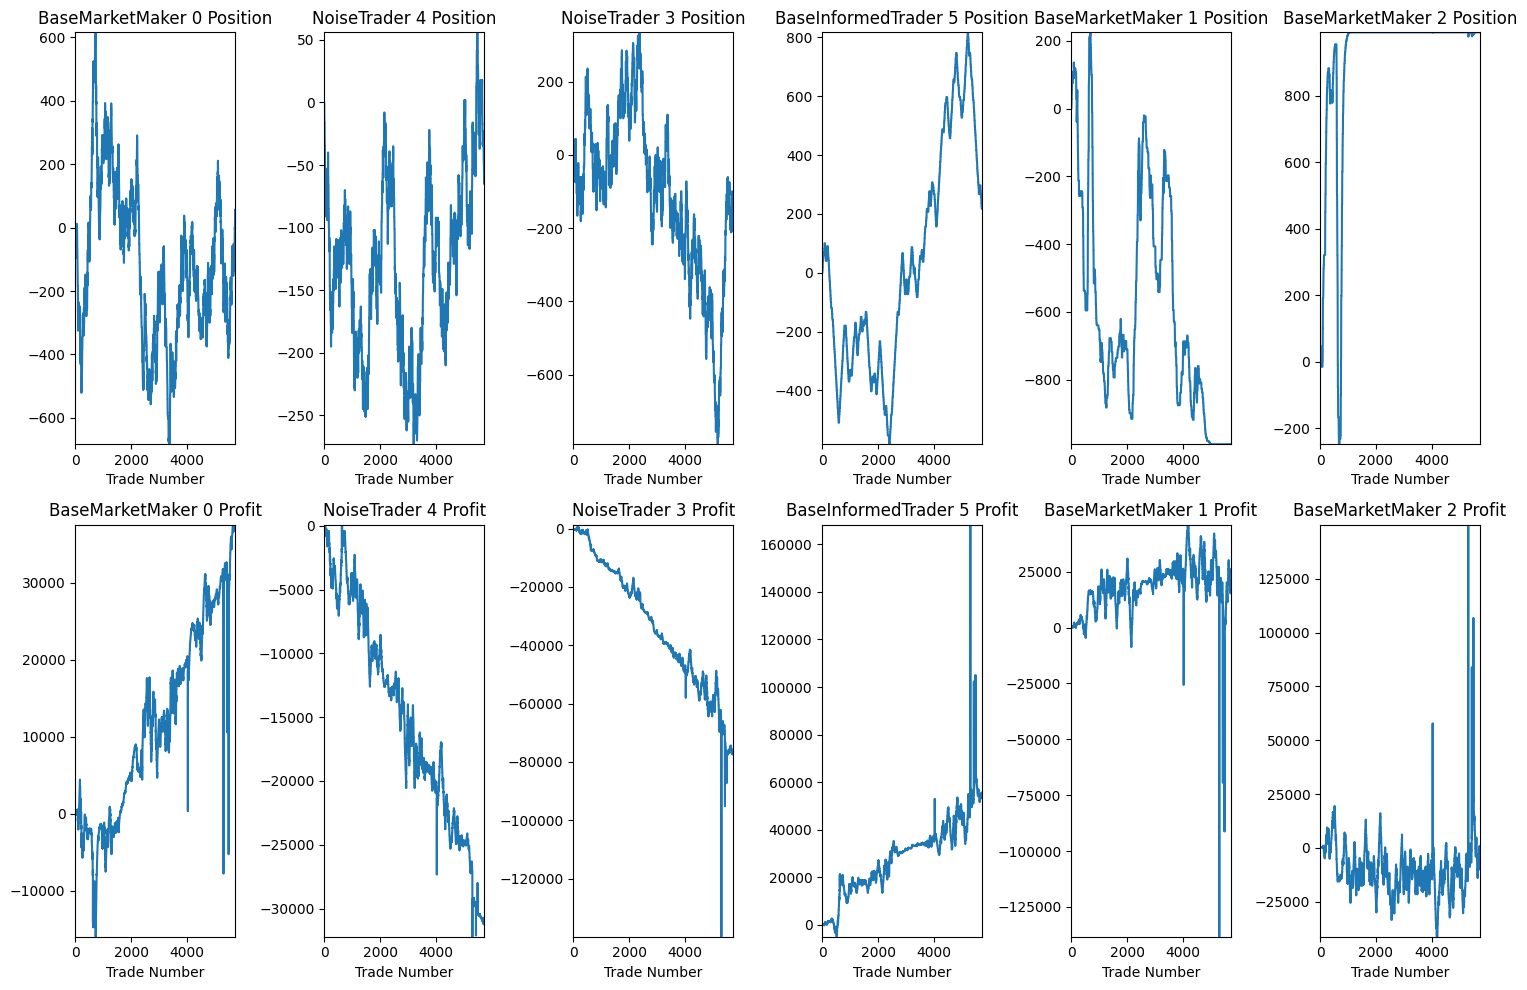

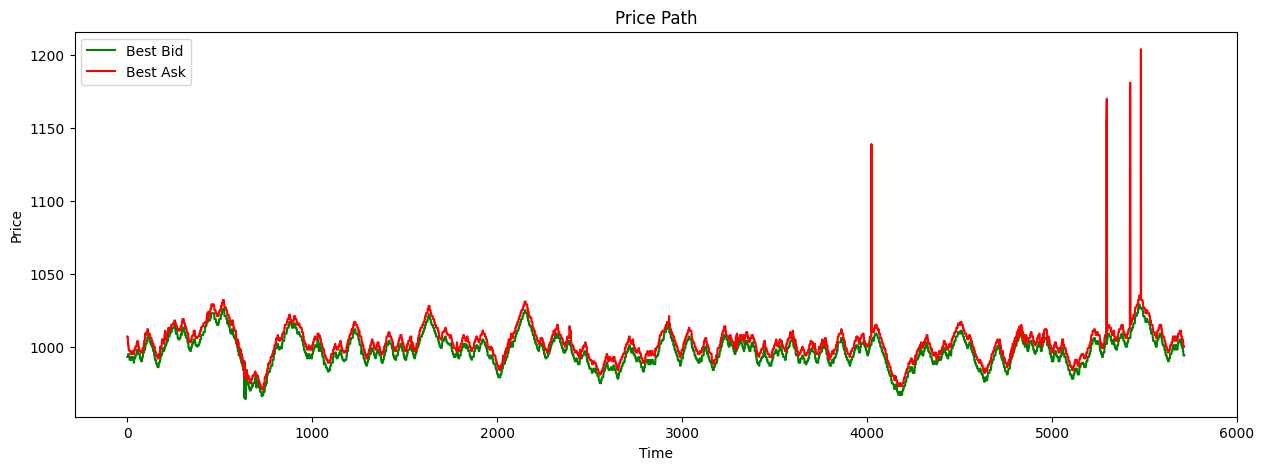

In [4]:
participant_comparison(market.participants)
price_path(market)

In [5]:
import pandas as pd
import numpy as np

def advanced_order_book_analysis(snapshots):
    data = defaultdict(lambda: {'midprice': 0, 'bids': {}, 'asks': {}})
    all_prices = set()
    
    def update_cumulative_volume(side, orders):
        cumulative = 0
        for price, volume in orders:
            cumulative += volume
            side[price] = cumulative
            all_prices.add(price)
    
    for snapshot in snapshots:
        time = snapshot['time']
        snapshot_data = data[time]
        
        bids = sorted(((b['price'], b['volume']) for b in snapshot['bid']), reverse=True)
        asks = sorted(((a['price'], abs(a['volume'])) for a in snapshot['ask']))
        
        if bids and asks:
            snapshot_data['midprice'] = (bids[0][0] + asks[0][0]) / 2
        
        update_cumulative_volume(snapshot_data['bids'], bids)
        update_cumulative_volume(snapshot_data['asks'], asks)
    
    times = sorted(data.keys())
    prices = np.arange(min(all_prices), max(all_prices) + 0.01, 0.01).round(2)
    
    midprice_data = [data[t]['midprice'] for t in times]
    midprice_df = pd.DataFrame({'midprice': midprice_data}, index=times)
    
    bids_data = np.array([[data[t]['bids'].get(p, 0) for p in prices] for t in times])
    asks_data = np.array([[data[t]['asks'].get(p, 0) for p in prices] for t in times])
    
    asks_df = pd.DataFrame(np.maximum.accumulate(asks_data, axis=1), index=times, columns=prices)
    bids_df = pd.DataFrame(np.maximum.accumulate(bids_data[:, ::-1], axis=1)[:, ::-1], index=times, columns=prices)
    
    combined = asks_df.add(bids_df).T[::-1]
    
    return midprice_df, combined[::50]

midprice_df, combined = advanced_order_book_analysis(market.ob_snapshots)

KeyboardInterrupt: 

<Axes: >

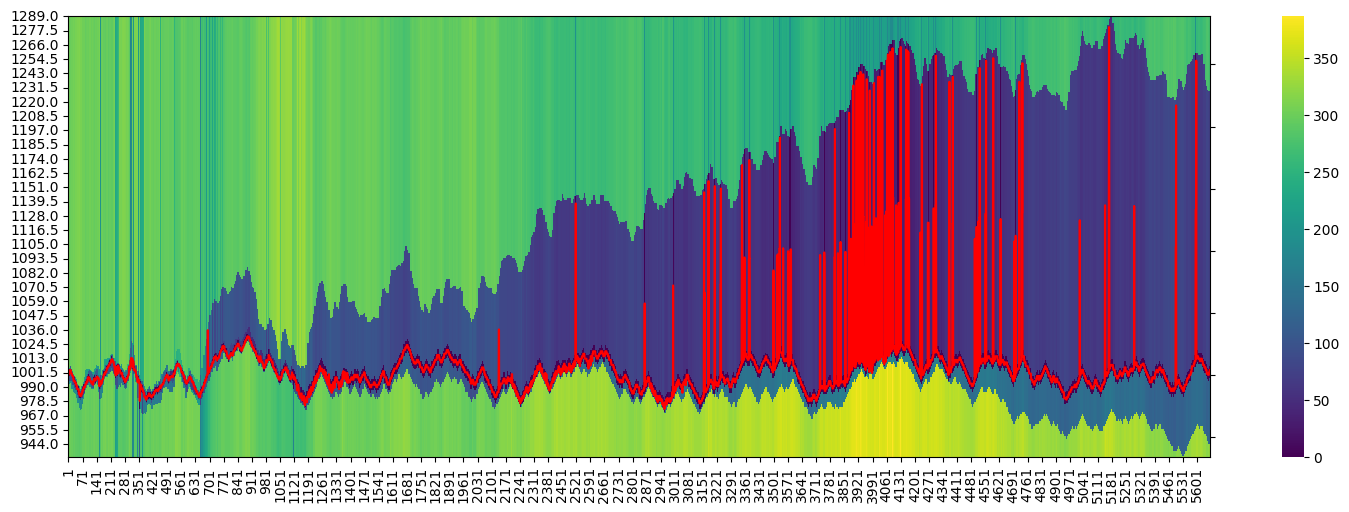

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
fig.tight_layout()
sns.heatmap(combined, cmap='viridis')
ax2 = ax.twinx()
ax2.set_ylim(combined.index[-1], combined.index[0])
ax2.set_yticklabels([])
midprice_df.plot(ax=ax2, color='red', legend=False)



In [ ]:
combined.iloc[:,193:]

,194,195,196,197,198,199,200,201,202,203,...,5657,5658,5659,5660,5661,5662,5663,5664,5665,5666
1289.0,298,298,298,298,298,291,291,291,291,291,...,275,275,275,275,272,272,272,271,271,271
1288.5,298,298,298,298,298,291,291,291,291,291,...,275,275,275,275,272,272,272,271,271,271
1288.0,298,298,298,298,298,291,291,291,291,291,...,275,275,275,275,272,272,272,271,271,271
1287.5,298,298,298,298,298,291,291,291,291,291,...,275,275,275,275,272,272,272,271,271,271
1287.0,298,298,298,298,298,291,291,291,291,291,...,275,275,275,275,272,272,272,271,271,271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936.0,300,300,300,300,300,306,306,306,306,306,...,322,322,322,322,325,325,325,326,326,326
935.5,300,300,300,300,300,306,306,306,306,306,...,322,322,322,322,325,325,325,326,326,326
935.0,300,300,300,300,300,306,306,306,306,306,...,322,322,322,322,325,325,325,326,326,326
934.5,300,300,300,300,300,306,306,306,306,306,...,322,322,322,322,325,325,325,326,326,326


In [ ]:
msgs = pd.DataFrame(market.msg_history)
msgs.columns = ['timestamp', 'type', 'description']
msgs[msgs['timestamp'] > 193].head(20)

,timestamp,type,description
389,194,ADD,"LMT P: 1000 V: +124, FROM: 2"
390,194,ADD,"LMT P: 1014 V: -75, FROM: 2"
391,195,ADD,MKT V: +46 FROM: 3
392,195,TRADE,"46 @ 1008, AGG: 1"
393,196,ADD,"LMT P: 1005 V: +95, FROM: 0"
394,196,ADD,"LMT P: 1011 V: -104, FROM: 0"
395,197,ADD,MKT V: -12 FROM: 4
396,197,TRADE,"12 @ 1005, AGG: -1"
397,198,ADD,"LMT P: 1000 V: -10, FROM: 5"
398,198,TRADE,"10 @ 1005, AGG: -1"


<Axes: xlabel='None', ylabel='midprice'>

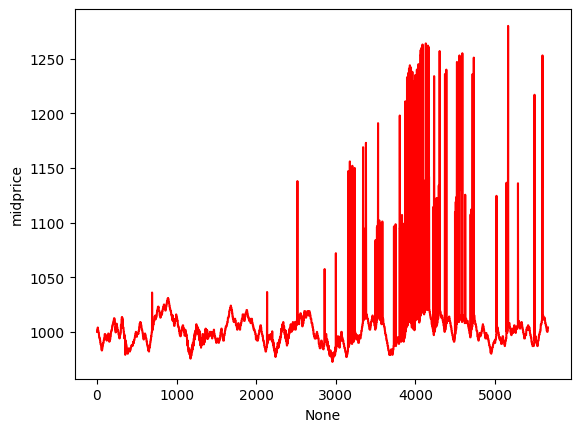

In [ ]:
sns.lineplot(x=midprice_df.index, y=midprice_df['midprice'], color='red')

In [ ]:
participants_report(market.participants)

,BaseMarketMaker_2,BaseInformedTrader_5,NoiseTrader_4,BaseMarketMaker_1,NoiseTrader_3,BaseMarketMaker_0
final_profit,204795.00,61429.00,-119195.00,138299.00,-302361.00,17033.00
final_position,991.00,-442.00,-41.00,-263.00,746.00,-991.00
profit_per_state,36.14,10.84,-21.04,24.41,-53.36,3.01
std_profit_per_state,24197.93,7806.51,3021.12,15884.08,19337.24,25556.37
information_ratio,0.00,0.00,-0.01,0.00,-0.00,0.00
total_trades,593.00,717.00,1049.00,2587.00,1109.00,593.00
volume_traded,6315.00,6638.00,10301.00,37625.00,26884.00,8199.00
profit_per_volume,32.43,9.25,-11.57,3.68,-11.25,2.08
average_trade_size,10.65,9.26,9.82,14.54,24.24,13.83
fill_rate,0.03,1.00,1.00,0.19,1.00,0.04


<Axes: xlabel='time'>

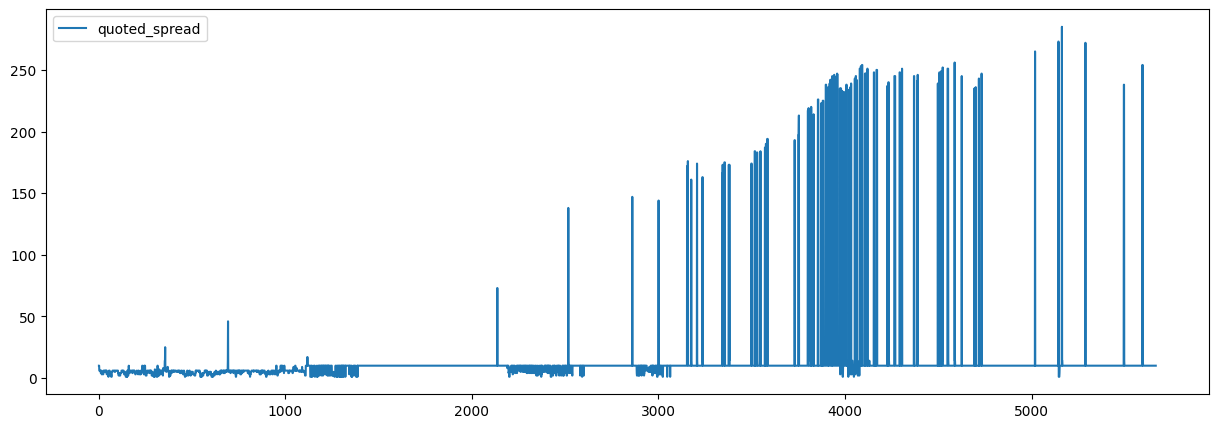

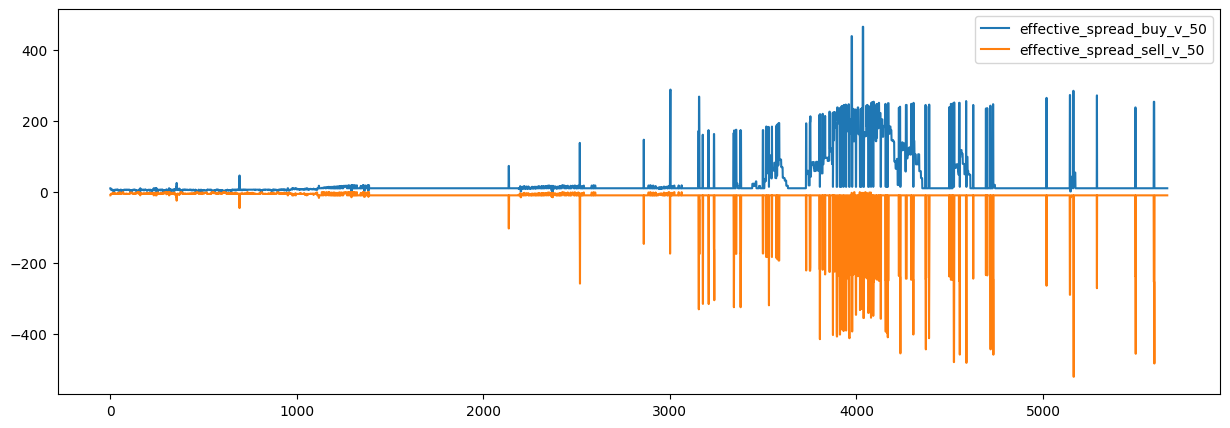

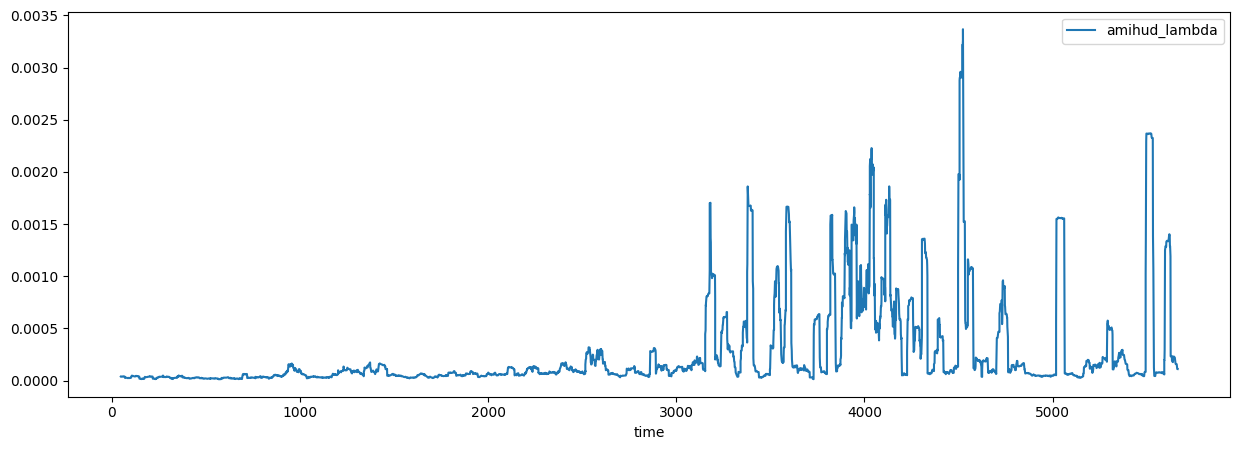

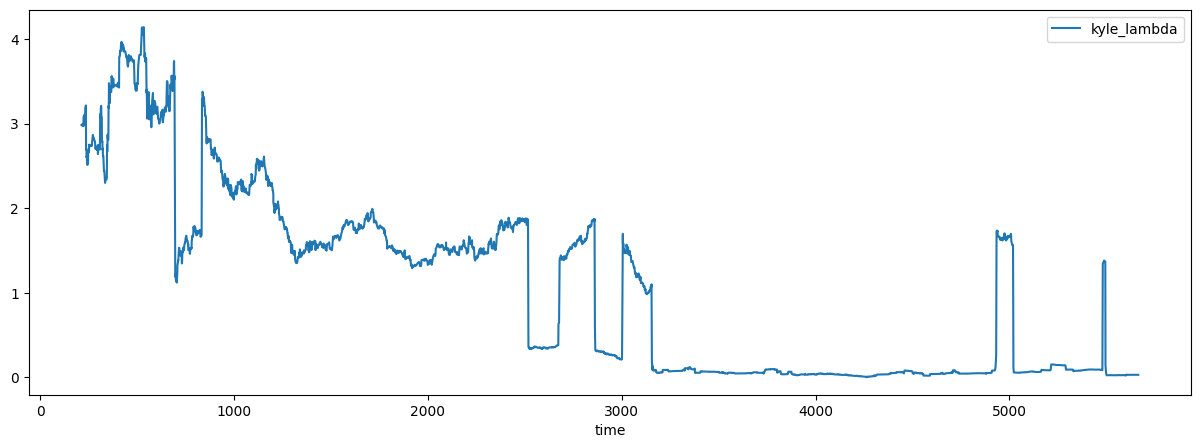

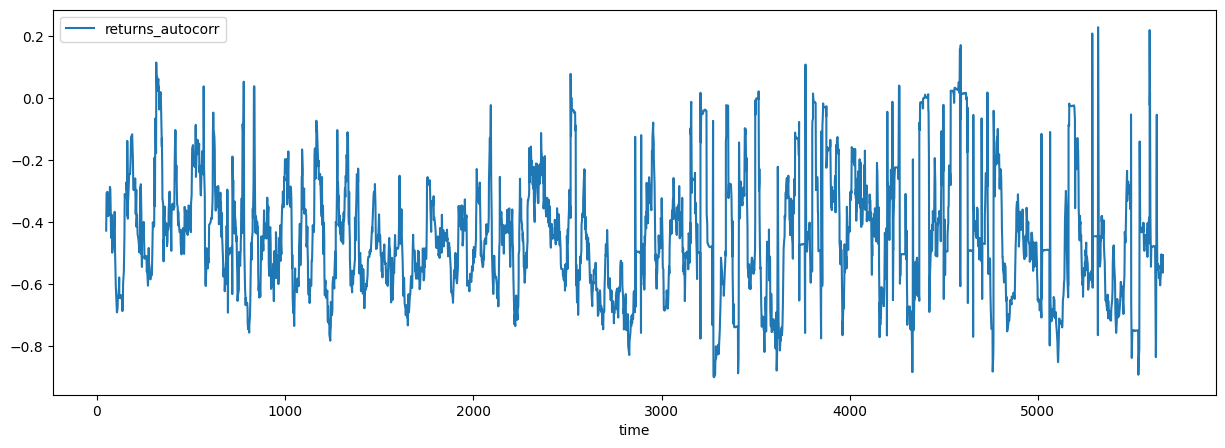

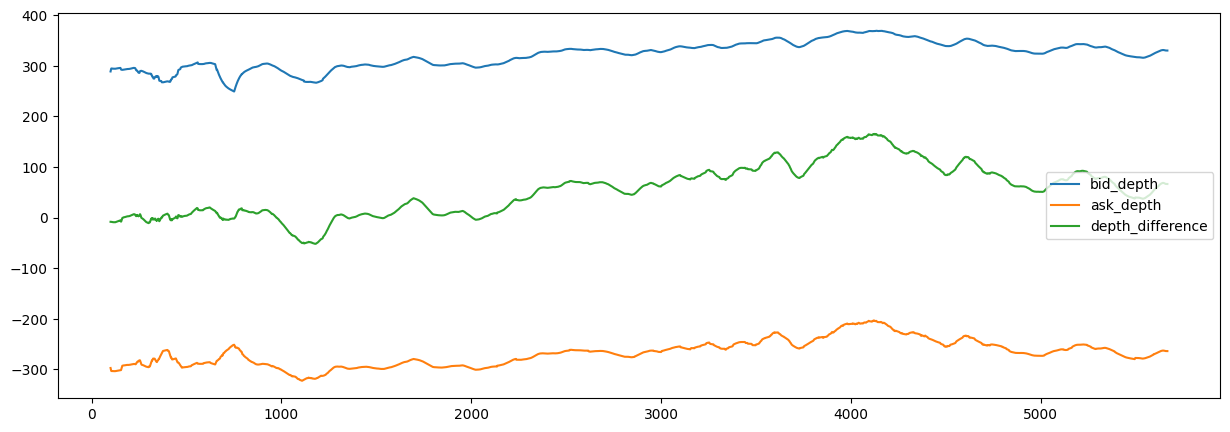

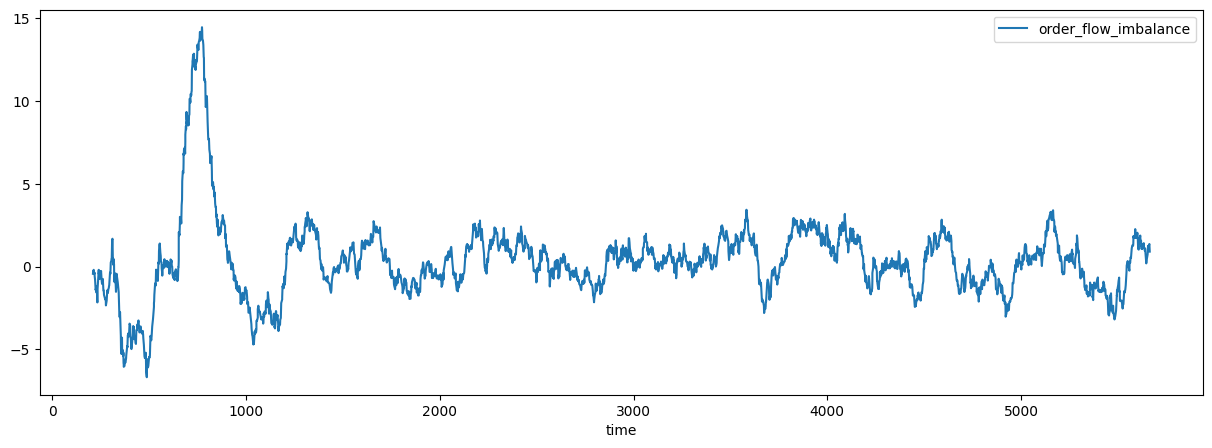

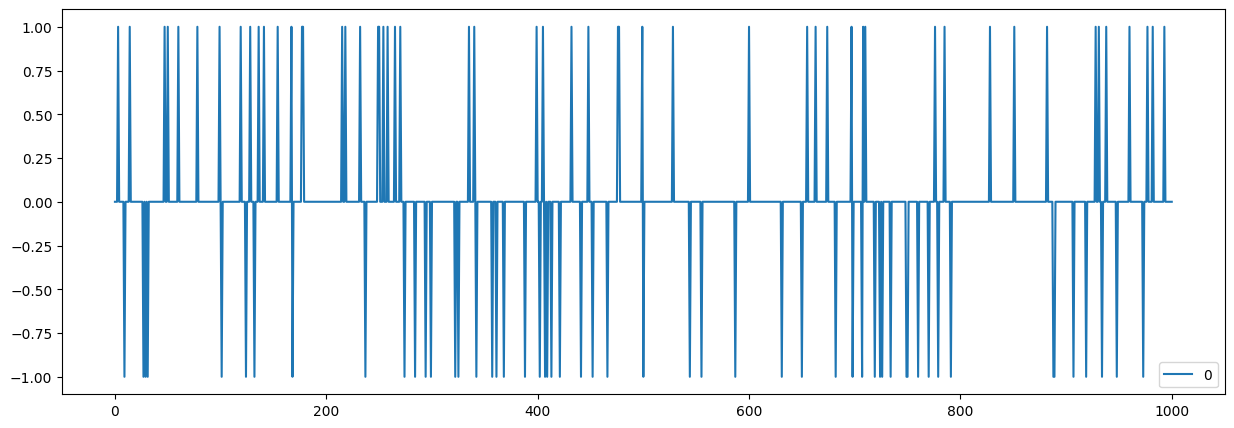

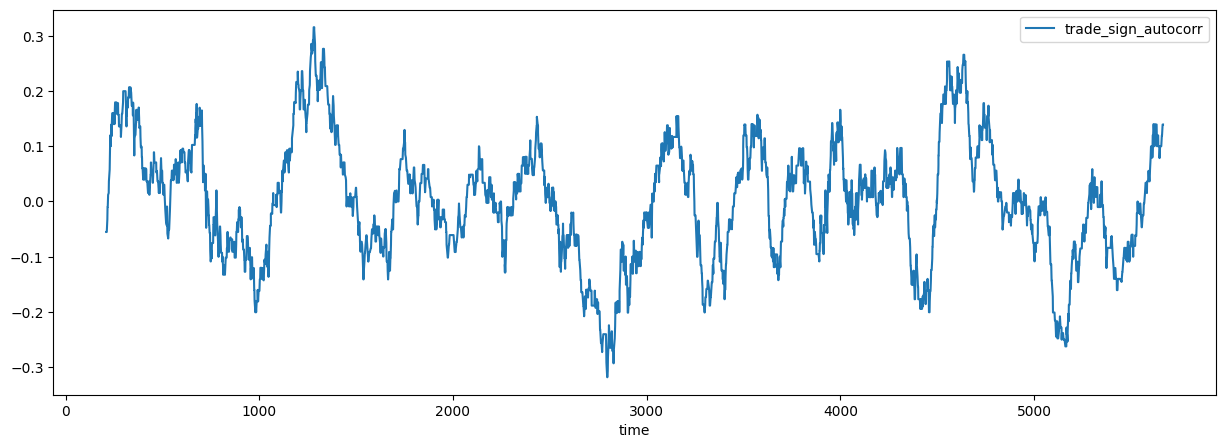

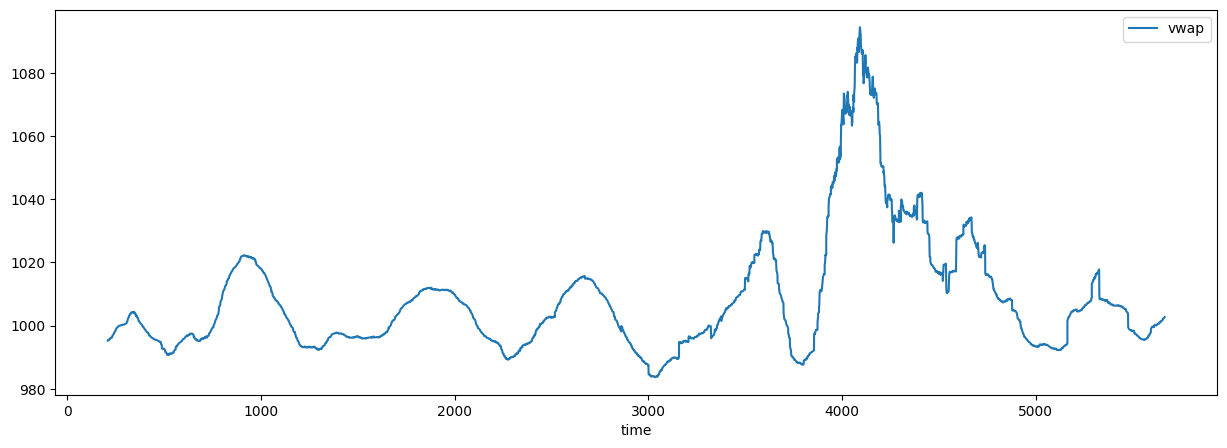

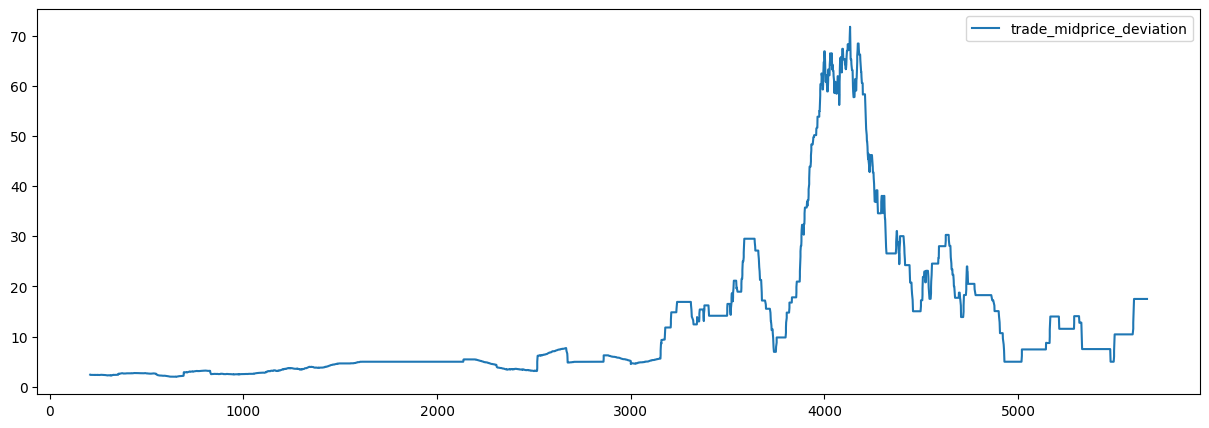

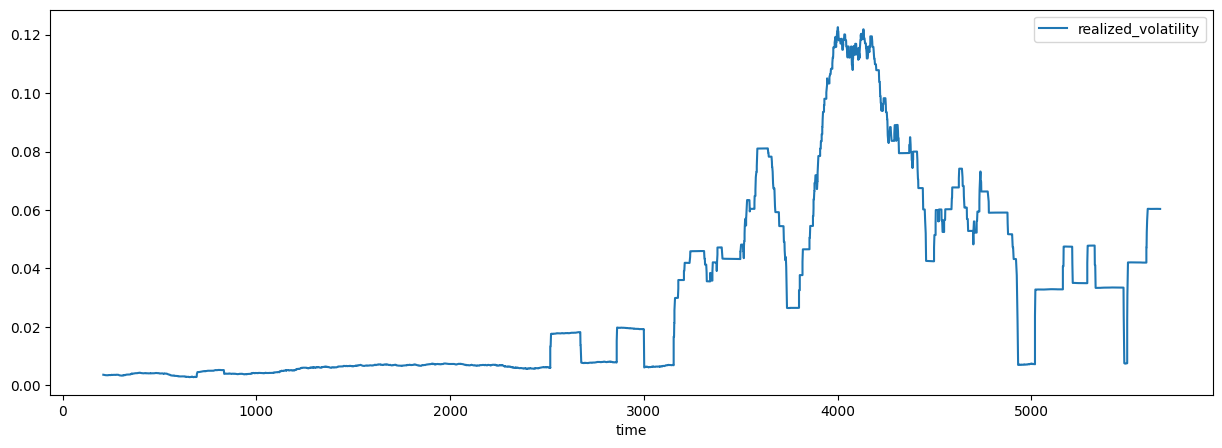

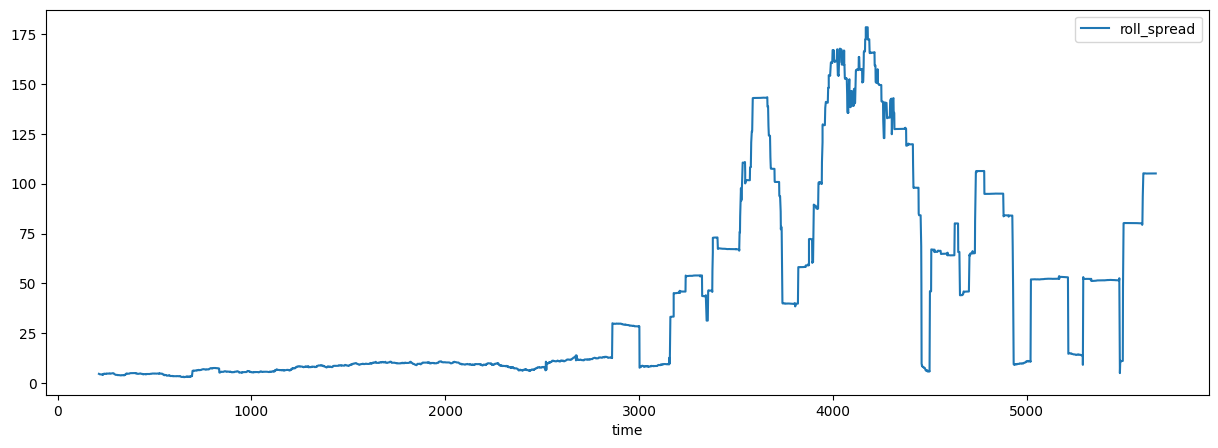

In [ ]:
quoted_spread(market).plot(figsize=(15,5))
effective_spread(market, volume=50).plot(figsize=(15,5))
amihud_illiquidity(market).plot(figsize=(15,5))
kyle_lambda(market).plot(figsize=(15,5))
returns_autocorrelation(market).plot(figsize=(15,5))
order_book_depth(market).plot(figsize=(15,5))
order_flow_imbalance(market).plot(figsize=(15,5))
news_goodness(market).plot(figsize=(15,5))
trade_sign_autocorrelation(market).plot(figsize=(15,5))
vwap(market).plot(figsize=(15,5))
trade_midprice_deviation(market).plot(figsize=(15,5))
realized_volatility(market).plot(figsize=(15,5))
roll_spread_estimator(market).plot(figsize=(15,5))

In [ ]:
market.ob_snapshots[450]

{'bid': [{'price': 986, 'volume': 85},
  {'price': 985, 'volume': 70},
  {'price': 977, 'volume': 144}],
 'ask': [{'price': 991, 'volume': -55},
  {'price': 992, 'volume': -114},
  {'price': 995, 'volume': -129}],
 'time': 451}

In [ ]:
from dill import dump, load

In [ ]:
with open('market.pkl', 'wb') as f:
    dump(market, f)

In [ ]:
with open('market.pkl', 'rb') as f:
    market = load(f)

In [ ]:
new_market = ContinousDoubleAuction.load('market.pkl')

In [ ]:
new_market